In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from Ge_calculation import GAP, MD_run
from Ge_analysis import *
import matplotlib.pyplot as plt
import pickle
from ase.io.cfg import read_cfg
import numpy as np
import os
from ase import build
from ase.atoms import Atoms
from quippy.potential import Potential
from quippy.descriptors import Descriptor
from ase.io.proteindatabank import read_proteindatabank, write_proteindatabank
from ase.io.lammpsdata import write_lammps_data
from scipy.optimize import curve_fit
from ase.io import Trajectory
from ase.io import read
from ase.eos import EquationOfState
from ase.visualize import view
from copy import deepcopy
from ase.io.castep import read_castep_castep, read_param
from ase.io import read
from ase.io.extxyz import read_xyz, write_xyz
import pandas as pd
from ase.lattice import hexagonal, tetragonal, orthorhombic
from ase.constraints import StrainFilter, UnitCellFilter, ExpCellFilter, FixAtoms
from ase.optimize import BFGS
import pymatgen.ext.matproj as mp
import pymatgen.core.periodic_table as pt
import pymatgen.io.ase as pase
import cProfile
import re
from sklearn import decomposition

In [4]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans serif"]})
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{siunitx}']

<ipython-input-4-781b817d2483>:6: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [


In [5]:
GE = '/Users/Moji/Documents/Summer20/Ge/'
os.chdir('/Users/Moji/Documents/Summer20/Ge/')
pot_dir ='/Users/Moji/Documents/Summer20/Ge/Potentials/rescaling/'

In [4]:
hp64_GAP = GAP(train_file=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_train.xyz',
               val_file=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_validate.xyz',
               pot=GE+'Potentials/hp_liquid/hpliq_64/hpliq_64_as5_ds002_vT.xml',
               sorted_order=[0, 3, 4, 1, 2])
hp64_GAP.load(GE+'Pickles/hp64_GAP')

Training set structure count: 231
Validation set structure count: 50
Reading xyz file (may take a while)
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']


In [6]:
Si_hp_MDs = [MD_run(GE+'/MD_runs/Si_hp_liquid/'+i) for i in
sorted([i for i in os.listdir(GE+'/MD_runs/Si_hp_liquid') if 'run' in i],
       key=lambda x: int(x.split('_')[-1]))]

In [7]:
Ge_exp_Sq = np.genfromtxt('/Users/Moji/Documents/paper_data/Ge_Sq_exp.txt', delimiter=', ').T

In [ ]:
Ge_hpliq_64_1000MD = MD_run(GE+'MD_runs/Ge_hp/hpliq_64/run_1000_001')

In [9]:
tmp = Ge_hpliq_64_1000MD.structure_factors(selection=([i for i in range(40,120)]),
                              rings_dir=GE+'MD_runs/Ge_hp/hpliq_64/rings',
                              read_only=True)
#resc_amo_MD.bin_fit(s_selection=range(0,-1,1), q_selection=[1,12], nbins=200)
Ge_hpliq_64_1000MD.bin_fit(q_selection=[1,12], nbins=200)

In [10]:
descriptor = Descriptor(
                        'soap average=T l_max=6 n_max=12 atom_sigma=0.5 \
                              cutoff=5.0 cutoff_transition_width=1.0 \
                              central_weight=1.0')
descs = [np.array([descriptor.calc_descriptor(i) for i in j.df['Configs']])
         for j in Si_hp_MDs]
zeta = 4
a = flatten(descs)
k_mat = np.array([[2 - 2*np.dot(i[0]**zeta, j[0]**zeta) for j in a] for i in a])
pca = decomposition.PCA(n_components=2)
pca.fit(k_mat)
red = pca.fit_transform(k_mat)


In [11]:
p = pd.concat([i.df['f_PressAve'] for i in Si_hp_MDs])
c = pd.concat([i.df['f_TempAve'] for i in Si_hp_MDs])


In [14]:
import matplotlib.pyplot as plt

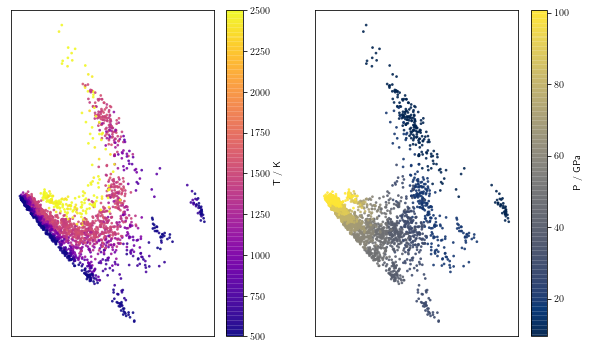

In [16]:
fig, axs = plt.subplots(1,2, figsize=(10,6))
cmap = plt.cm.plasma
norm = mpl.colors.Normalize(vmin=500, vmax=2500)
im1 = axs[0].scatter(red.T[0], red.T[1], c=c, cmap='plasma', norm=norm, alpha=0.8, s=3)
cbar = fig.colorbar(im1, ax=axs[0])
cbar.set_label('T / K')
im2 = axs[1].scatter(red.T[0], red.T[1], c=p*1e-4, cmap='cividis', alpha=0.8, s=3)
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label('P / GPa')
axs[0].get_xaxis().set_visible(False)
axs[0].get_yaxis().set_visible(False)
axs[1].get_xaxis().set_visible(False)
axs[1].get_yaxis().set_visible(False)
fig.savefig(GE+'Analysis/Si_hp_MDs_simmap.png', bbox_inches='tight', dpi=100)

In [19]:
for i, val in enumerate(Si_hp_MDs):
    tmp = val.structure_factors([j for j in range(40,120)],
                                  rings_dir=GE+'MD_runs/Si_hp_liquid/rings_'+str(i),
                                  read_only=False)
    val.bin_fit_g()

R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully
R.I.N.G.S ran successfully


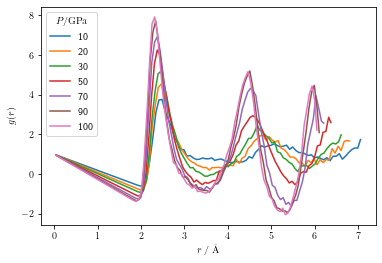

In [30]:
fig, axs = plt.subplots()
for ct,i in enumerate(Si_hp_MDs):
    if ct not in [3, 5, 7]:
        #axs.errorbar(*i.gr_av, yerr=i.gr_std[1],
        axs.errorbar(*i.gr_av, yerr=None,
                    label='{}'.format(int(i.run_dir.split('/')[-1].split('_')[-1])*10))

axs.legend(title=r"$P / \si{GPa}$")
axs.set(xlabel=r'$r \;/\; \si{\angstrom}$', ylabel=r'$g(r)$')
fig.savefig(GE+'Analysis/Si_hp_MDs_gr.png', bbox_inches='tight', dpi=100)

In [39]:
os.chdir('../')

In [43]:
at = read_cfg('/Users/Moji/Documents/Summer20/Ge/MD_runs/Ge_hp/hpliq_amoliq/run_64001/NPT/dump_npt_Ge_gap.240000.cfg')

In [66]:
from ase.neighborlist import neighbor_list
from ase.data import covalent_radii
from ase.io.cfg import read_cfg
from sys import argv

at = read_cfg(argv.pop(-1))
args = argv.split()
arg_dict = {}
for i in args:
     arg_dict.update(*i.split('=')):

if 'r' in arg_dict.keys:
    r = arg_dict['r']
else:
    r = covalent_radii[at.get_atomic_numbers()[0]]*2.5
i = neighbor_list('i', at, r)
coord = np.bincount(i)
stat = np.bincount(coord)

print('{0:^10s}   {1:^10s}   {2:^10s}'.format('C.N.', 'Count', r'%'))
print('-'*36)
for i, val in enumerate(stat[1:]):
    print('{0:^10d}   {1:^10d}   {2:^8.2f}'.format(i+1, val, val/sum(stat)*100))

at.set_atomic_numbers([32]*64)

In [67]:
i = neighbor_list('i', at, covalent_radii[at.get_atomic_numbers()[0]]*2.5)
coord = np.bincount(i)
stat = np.bincount(coord)

print('{0:^10s}   {1:^10s}   {2:^10s}'.format('C.N.', 'Count', r'%'))
print('-'*36)
for i, val in enumerate(stat[1:]):
    print('{0:^10d}   {1:^10d}   {2:^8.2f}'.format(i+1, val, val/sum(stat)*100))

In [65]:
covalent_radii[at.get_atomic_numbers()[0]]*2.5


2.7750000000000004

In [14]:
Si_exp_Sq = np.genfromtxt('/Users/Moji/Documents/paper_data/Si_Sq_exp_Waseda1974.txt',
                          delimiter=', ').T
Si_exp_Sq[1] -= 0.5

In [29]:
aSi_exp_Sq = np.genfromtxt('/Users/Moji/Documents/paper_data/a-Si_x-ray_Laaziri1999.txt',
                          delimiter=', ').T

In [32]:
Si_litDB_liqamo_64 = MD_run(GE+'MD_runs/Si_litDB_amoliq/run_64001')
Si_litDB_liq_amo_dia_64 =  MD_run(GE+'MD_runs/Si_litDB_amo_liq_dia/run_64001')

In [ ]:
tmp = Si_litDB_liqamo_64.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                                                        rings_dir=GE+'MD_runs/Si_litDB_amoliq/Sq_rings',
                                                        opts={'Angles':True},
                                                        read_only=False)
tmp = Si_litDB_liq_amo_dia_64.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                                                             rings_dir=GE+'MD_runs/Si_litDB_amo_liq_dia/Sq_rings',
                                                             opts={'Angles':True},
                                                             read_only=False)

Si_litDB_liqamo_64.bin_fit(s_selection=[i for i in range(0,90)], q_selection=[0.5,12])
Si_litDB_liq_amo_dia_64.bin_fit(s_selection=[i for i in range(0,90)], q_selection=[0.5,12])

In [19]:
Si_litDB_full_4000 = MD_run(GE+'MD_runs/Si_litDB_full_4000/run_1000_001')

Si_litDB_full_4000.structure_factors(selection=[i for i in range(30,120)]+[i for i in range(220,240)],
                                     rings_dir='Sq_rings',
                                     opts={'Angles':True},
                                     read_only=True)

In [27]:
full_liq = Si_litDB_full_4000.bin_fit(s_selection=[i for i in range(0,90)], q_selection=[0.5,12])
full_amo = Si_litDB_full_4000.bin_fit(s_selection=[i for i in range(90,110)], q_selection=[0.5,12])

[Text(0.5, 0, '$Q \\;/\\; \\si{\\angstrom}^{-1}$'),
 Text(0, 0.5, 'S(Q)'),
 (0.0, 14.0)]

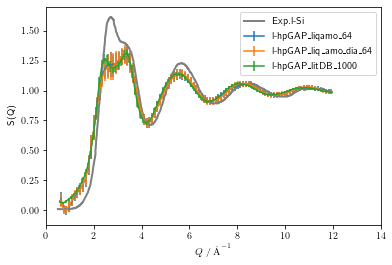

In [40]:
fig, axs = plt.subplots()
# axs.errorbar(*full_amo[0], yerr=full_amo[1][1],
#             label='a-hpGAP\_litDB\_1000')
axs.errorbar(*Si_litDB_liqamo_64.Sq_x_av, yerr=Si_litDB_liqamo_64.Sq_x_std[1],
            label='l-hpGAP\_liqamo\_64')
axs.errorbar(*Si_litDB_liq_amo_dia_64.Sq_x_av, yerr=Si_litDB_liq_amo_dia_64.Sq_x_std[1],
            label='l-hpGAP\_liq\_amo\_dia\_64')
axs.errorbar(*full_liq[0], yerr=full_liq[1][1],
            label='l-hpGAP\_litDB\_1000')
axs.plot(*Si_exp_Sq, color='Gray', linewidth=2, label='Exp.l-Si')
#axs.plot(*aSi_exp_Sq, color='k', linewidth=2, label='Exp. a-Si')
axs.legend()
axs.set(xlabel=r'$Q \;/\; \si{\angstrom}^{-1}$', ylabel='S(Q)', xlim=(0, 14))
#fig.savefig(GE+'Analysis/Sq_Si_litDB_full_4000.png', bbox_inches='tight', dpi=100)

In [ ]:
Si_litDB_full_4000.bin_fit(s_selection=[i for i in range(0,90)], q_selection=[0.5,12])

In [41]:
Si_litDB_liqamo_64.df.head()

,Configs,CPU,Temp,f_TempAve,Press,f_PressAve,f_PEAve_Atom,Volume,f_vAve,c_MSD[4]
1000,"(Atom('Si', [5.125355001, 2.1667184165, 0.1646...",33.039273,2424.8098,2469.0224,-4824.5699,2301.72120,-162.40100,1347.5811,1311.1770,25.144933
2000,"(Atom('Si', [2.6548230607999996, 0.17080501923...",66.218049,3183.5189,2548.5695,11245.4710,4094.84620,-162.42015,1240.0120,1273.5539,41.282861
3000,"(Atom('Si', [0.001584508156, 2.8448875136, 2.6...",100.224210,2670.8475,2413.2901,18907.2610,4733.83300,-162.37740,1232.8793,1316.5453,49.812680
4000,"(Atom('Si', [2.110037784, 2.740476888, 0.60751...",135.199190,2447.7993,2481.0516,13945.4340,-489.88991,-162.41260,1251.3267,1296.2640,75.775724
5000,"(Atom('Si', [0.9190902235499999, 2.5842311577,...",169.115780,2330.5110,2593.4622,-3482.4521,-3608.81460,-162.41099,1279.6533,1319.6029,99.579061


In [49]:
np.average([(tm := Si_litDB_liqamo_64.df['c_MSD[4]'])[i+1000] - tm[i] for i in range(20000,120000, 1000)])

9.3915974

In [111]:
def kernel_compare(cfgs, comp,
                   desc=Descriptor('soap average=T l_max=6 n_max=12 \
                                   atom_sigma=0.5 cutoff=5.0 \
                                   cutoff_transition_width=1.0 central_weight=1.0'),
                   zeta=4):
    '''calculates the average/std dev similarity kernel between a set of
    configs and a reference.
    Need to average the kernels for atomic environments?'''
    descs = np.array([desc.calc_descriptor(i)[0] for i in cfgs])
    comp_desc = desc.calc_descriptor(comp)[0]
    norm = np.einsum('ik,ik->i', descs, descs)
    norm_comp = np.dot(comp_desc, comp_desc)
    # employ einsum for this:
    k = np.array([(2 - 2*np.dot(i, comp_desc))**zeta for i in descs])

    return(k)

In [88]:
descriptor = Descriptor('soap average=T l_max=6 n_max=12 atom_sigma=0.5 \
                              cutoff=5.0 cutoff_transition_width=1.0 \
                              central_weight=1.0')
descs = np.array([descriptor.calc_descriptor(i) for i in Si_litDB_liqamo_64.df['Configs']])
zeta = 4
# a = flatten(descs)
# k_mat = np.array([[2 - 2*np.dot(i[0], j[0])**zeta for j in a] for i in a])
# pca = decomposition.PCA(n_components=2)
# pca.fit(k_mat)
# red = pca.fit_transform(k_mat)

In [80]:
test = np.array([[1,2,3,4], [10,20,30,40]])
test2 = np.array([[1,2,3,4], [3,4,5,6]])
print(np.einsum('ik,ik->i', test, test2))

[ 30 500]


In [113]:
tester = kernel_compare(Si_litDB_liqamo_64.df['Configs'], bSn)


In [61]:
with mp.MPRester() as m:
    results = m.query(criteria={"pretty_formula":'Si'},
                            properties=["exp.tags", "icsd_ids", "task_id", "density", "final_structure", ""])
    #results = [m.get_structure_by_material_id(i, conventional_unit_cell=True) for i in ['mp-78', 'mp-1061054']]

[{'exp.tags': ['Silicon'],
  'icsd_ids': [189396],
  'task_id': 'mp-1196961',
  'density': 1.9845847893263202,
  'final_structure': Structure Summary
  Lattice
      abc : 10.221459979417617 10.221459979417617 10.388793
   angles : 90.0 90.0 119.99999986677838
   volume : 939.9864436293609
        A : 5.11073 -8.852044 0.0
        B : 5.11073 8.852044 0.0
        C : 0.0 0.0 10.388793
  PeriodicSite: Si (7.0110, -1.8535, 7.1433) [0.7906, 0.5812, 0.6876]
  PeriodicSite: Si (3.2104, 1.8535, 7.1433) [0.2094, 0.4188, 0.6876]
  PeriodicSite: Si (3.2104, -1.8535, 3.2455) [0.4188, 0.2094, 0.3124]
  PeriodicSite: Si (7.0110, 1.8535, 3.2455) [0.5812, 0.7906, 0.3124]
  PeriodicSite: Si (3.2104, 1.8535, 3.2455) [0.2094, 0.4188, 0.3124]
  PeriodicSite: Si (7.0110, -1.8535, 3.2455) [0.7906, 0.5812, 0.3124]
  PeriodicSite: Si (7.0110, 1.8535, 7.1433) [0.5812, 0.7906, 0.6876]
  PeriodicSite: Si (3.2104, -1.8535, 7.1433) [0.4188, 0.2094, 0.6876]
  PeriodicSite: Si (3.1679, -5.4869, 8.4429) [0.6198, 0.

In [75]:
bSn = pase.AseAtomsAdaptor.get_atoms(results[18]['final_structure'])

In [89]:
np.shape(descs)

(240, 1, 547)

In [95]:
a = [descriptor.calc_descriptor(i) for i in Si_litDB_liqamo_64.df['Configs']]

In [104]:
[len(a[i][0]) for i in range(len(a))]

[547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547,
 547

In [108]:
Si_litDB_liqamo_64.df['Configs']

KeyError: 1